# Layered Model Starter Code

## Model Description 
This is a steady state, layered box model with recharge.

#### Dimensions: 
- 50 by 50 by 1
- dx = dy = 100 m
- dz = 100 m  

#### Topography
- Land surface 100m above the datum on the left hand side
- sloping linearly to 85m above the datum on the right hand side

#### Subsurface Properties: 
- Homogeneous 
- K = 1.0 m/day in x and y and 0.1 m/day in z.  
- Porosity = 0.35
- Specific yield = 0.3
- Storage coefficient=0.001  

#### Boundary Conditions: 
 - Left boundary constant head 85m
 - Right boundary is a constant head of 70m 
 - Recharge occurs at a rate of 5E-5 m/d uniformly across the domain
 
#### Well: 
 - Pumping well
     - Located at (2500, 2500)
     - Pumping at a rate of 500 m^3/day 

#### Layered Scenario
 - Low K layer - Kx=Ky=Kz=0.0001m/d
 - Extends from 25-35m above the base of the domain
 - The well is only completed in the lowest layer
     

## 1. Setup the environment

In [217]:
#the basics
import flopy
import numpy as np
import matplotlib as mp
import os

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import csv

#jupyter specific--included to show plots in notebook
%matplotlib inline 



## 2. Setup the input variables 

In [218]:
## model directory
moddir = '../../../modflow/mf2005'

## Discretization
nrow = 50                   #number of rows
ncol = 50                   #number of columns
nlay = 1                    #number of layers

dx= 100                     #width of grid cells in x direction 
dy= 100                     #width of grid cells in y direction 

Lx = ncol*dx                #width of domain in x
Ly = nrow*dy                #width of domain in y

# read in the surface elevation data from a csv file
with open('top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',')  
zbot = 0.                   #bottom elevation
dz = (ztop - zbot) / nlay   #cell height in z direction

## Timing
nper = 1                    #number of stress periods 
steady = [True]             #list noting the stress period type

## Subsurface properties
K_horiz = 0.75              #assign horizontal hydraulic conductivity 
K_vert = 0.25               #assign vertical hydraulic conductivity (along z axis)
n = 0.35                    #assign porosity
Ss = 0.001                  #assign storage coefficient
Sy = 0.3                    #assign specific yield
uncnf = 1       #           0=confined, >0 = unconfined

## Recharge
recharge = 5e-5             #m/day

## Well
pumping = -500              #m3/day
well_xy= [2500, 2500]       #xy location of well 
well_row = np.floor((nrow-1)-(well_xy[1]/dy))       #convert the y location to a row
well_col=np.floor(well_xy[0]/dx-1)                  #convert the x location to a column
well_loc = (0, well_row, well_col)                  #Well loc should be layer, row, column
print(well_loc)

## Boundary conditions
h_left = 85
h_right = 70

(0, np.float64(24.0), np.float64(24.0))


## 3. Setup and run MODFLOW for the =One layer= scenario 

In [219]:
#Initialize the model
modelname1 = "OneLayer"

# setup the object for the one-layer model
m1 = flopy.modflow.Modflow(modelname1, exe_name = moddir)


#NOTE: Discretization - dis
dis = flopy.modflow.ModflowDis(model=m1, nlay=nlay, nrow=nrow, ncol=ncol, delr=dx, delc=dy, top=ztop, botm=zbot, itmuni = 4, lenuni = 2, nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1                  #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,-1] = -1                 #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right           #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left            #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m1, ibound=ibound, strt=H_init)


#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m1, laytyp=uncnf, hk=K_horiz, vka=K_vert, ss=Ss, sy=Sy, storagecoefficient=True, ipakcb=53) 


#Recharge 
rech_zone = np.zeros((nrow,ncol))   #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone + recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m1, rech=rech_zone, ipakcb=53)  #create rch object


#Well
well_1 = [i for i in well_loc] + [pumping]
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]}
wel = flopy.modflow.ModflowWel(model=m1, stress_period_data=wel_spd)


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 
oc = flopy.modflow.ModflowOc(model=m1, stress_period_data=spd, compact=True)


#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m1)


Well 1 [layer, row, column, flux]: 
 [0, np.float64(24.0), np.float64(24.0), -500]


#### 3.1 Write the inputs and run the Model

In [220]:
#write the inputs
m1.write_input()    

#Run the model 
success, mfoutput = m1.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: OneLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 20:11:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 20:11:28
 Elapsed run time:  0.023 Seconds

  Normal termination of simulation


#### 4.1 view the list file

In [221]:
lst = os.path.join(m1.model_ws, f"{m1.name}.list")
with open(lst, "r") as f:
    tail = f.readlines()[-40:]
print("".join(tail))

     ------------------                 ------------------------

           IN:                                      IN:
           ---                                      ---
             STORAGE =           0.0000               STORAGE =           0.0000
       CONSTANT HEAD =         544.7653         CONSTANT HEAD =         544.7653
               WELLS =           0.0000                 WELLS =           0.0000
            RECHARGE =        1200.0000              RECHARGE =        1200.0000

            TOTAL IN =        1744.7653              TOTAL IN =        1744.7653

          OUT:                                     OUT:
          ----                                     ----
             STORAGE =           0.0000               STORAGE =           0.0000
       CONSTANT HEAD =        1244.7653         CONSTANT HEAD =        1244.7653
               WELLS =         500.0000                 WELLS =         500.0000
            RECHARGE =           0.0000              RECHARG

## 4. Setup and run MODFLOW for the =Three layer= scenario 

In [222]:
#Initialize the model
modelname3 = "ThreeLayer"
m3 = flopy.modflow.Modflow(modelname3, exe_name = moddir)

## Make some changes to the parameters
nlay2=3  #three layers instead of 1
botm = np.zeros((nlay2,nrow,ncol)) # initialize array of zeros for bottom elevation for each model cell (dim: nlay,nrow,ncol)
botm[1,:,:] = 25.                  # bottom elevation of middle layer (1) is 25 m
botm[0,:,:] = 35.                  # bottom elevation of top layer (0) is 35 m 

## Make a arrays for the K values
Kz = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

Kh = np.zeros((nlay2,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz                  # assign the original value to the entire array
Kh[1,:,:] = 0.0001                   # Replace the K in the middle layer with the lower value

#Discretization - dis
dis = flopy.modflow.ModflowDis(model=m3, nlay=nlay2, nrow=nrow, ncol=ncol, delr=dx, delc=dy, top=ztop, botm=botm, itmuni = 4, lenuni = 2, nper=nper, steady=steady)


# Boundary and initial conditions - bas
#Define cell activity (IBOUND)
ibound = np.ones((nlay2, nrow, ncol), dtype=np.int32) #integer array of dim (z,y,x), makes all cells active                                                     
ibound[:,:,0] = -1                  #replace leftmost column (all zs, all ys, first x) with -1 to indicate constant head
ibound[:,:,-1] = -1                 #replace rightmost column (all zs, all ys, first x) with -1 to indicate constant head
#setup initial heads as 1 everywhere except on the boundaries
H_init = np.ones((nlay2, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right           #initialize the entire domain to the right head value
H_init[:, :, 0] = h_left            #replace first (left) col with desired head value
bas = flopy.modflow.ModflowBas(m3, ibound=ibound, strt=H_init)


#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m3, laytyp=uncnf, hk=Kh, vka=Kz, ss=Ss, sy=Sy, storagecoefficient=True, ipakcb=53) 


#Recharge 
rech_zone = np.zeros((nrow,ncol))               #define an array of zeros of dim (nrow,ncol)
rech_zone=rech_zone+recharge
rch = flopy.modflow.mfrch.ModflowRch(model=m3, rech=rech_zone, ipakcb=53)     #create rch object


#Well
well_loc = (2,well_row,well_col)    #Well loc should be layer, row, column
well_1 = [i for i in well_loc] + [pumping]
print("Well 1 [layer, row, column, flux]: \n", well_1)
wel_spd = {0: [well_1]}             #putting the well in the bottom layer
wel = flopy.modflow.ModflowWel(model=m3, stress_period_data=wel_spd)


#Output control - OC 
spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 


oc = flopy.modflow.ModflowOc(model=m3, stress_period_data=spd, compact=True)


#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m3)

Well 1 [layer, row, column, flux]: 
 [2, np.float64(24.0), np.float64(24.0), -500]


## Bonus: Add a river

In [223]:
river = True
if river:
    # ---- choose where the river will be ----
    riv_row = 24
    # riv_cols = np.arange(4, 41)   # 4..40 inclusive
    riv_cols = np.arange(0, ncol)   # all columns
    lay = 0

    # Use the model top to set stage (a little below land surface)
    top = ztop  # you already loaded this from top_elev.csv

    riv_spd = []
    riv_hds = []
    for j in riv_cols:
        stage = float(top[riv_row, j] - 1.5)     # water surface
        rbot  = float(stage - 3.0)               # riverbed bottom
        riv_hds.append(stage-rbot)
        # conductance ~ Kbed * width * length / thickness  (simple learning pick)
        cond  = 2000.0
        riv_spd.append([lay, riv_row, int(j), stage, cond, rbot])

    riv = flopy.modflow.ModflowRiv(
        m3,
        stress_period_data={0: riv_spd}
    )

print(m3.get_package_list())

['DIS', 'BAS6', 'LPF', 'RCH', 'WEL', 'OC', 'PCG', 'RIV']


In [224]:
#write the inputs
m3.write_input()    

#Run the model 
success, mfoutput = m3.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')

FloPy is using the following executable to run the model: ../../../modflow/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ThreeLayer.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 20:11:28

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2026/02/15 20:11:28
 Elapsed run time:  0.071 Seconds

  Normal termination of simulation


In [225]:
lst = os.path.join(m3.model_ws, f"{m3.name}.list")
with open(lst, "r") as f:
    tail = f.readlines()[-40:]
print("".join(tail))

           IN:                                      IN:
           ---                                      ---
             STORAGE =           0.0000               STORAGE =           0.0000
       CONSTANT HEAD =           3.1520         CONSTANT HEAD =           3.1520
               WELLS =           0.0000                 WELLS =           0.0000
       RIVER LEAKAGE =        5531.8120         RIVER LEAKAGE =        5531.8120
            RECHARGE =        1200.0000              RECHARGE =        1200.0000

            TOTAL IN =        6734.9639              TOTAL IN =        6734.9639

          OUT:                                     OUT:
          ----                                     ----
             STORAGE =           0.0000               STORAGE =           0.0000
       CONSTANT HEAD =        6234.9639         CONSTANT HEAD =        6234.9639
               WELLS =         500.0000                 WELLS =         500.0000
       RIVER LEAKAGE =           0.0000      

# 5. Plot the domains
### 5.1 Plan view of the domain

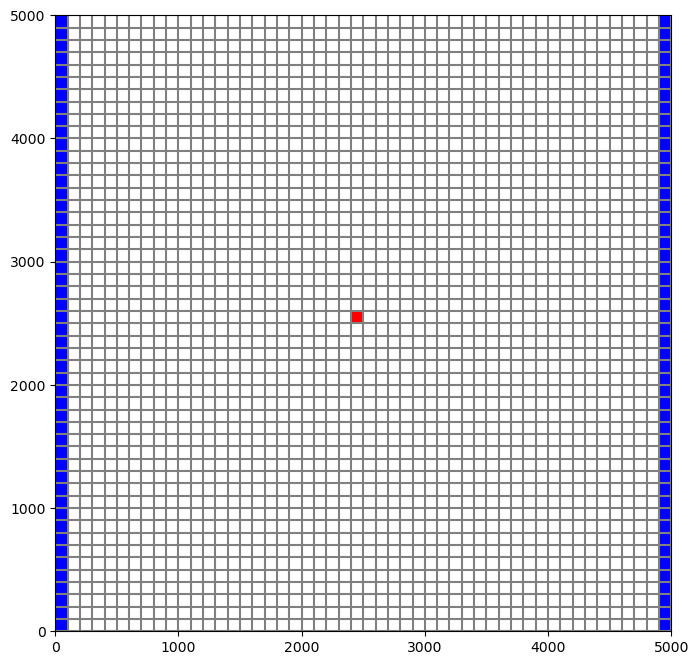

In [226]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')
mapview = flopy.plot.PlotMapView(model=m1)
ibound = mapview.plot_ibound()
wel = mapview.plot_bc("WEL")
linecollection = mapview.plot_grid()

### 5.2 Cross section of the layered model
For more examples of cross section plotting check out this notebook: https://github.com/modflowpy/flopy/blob/develop/examples/Notebooks/flopy3.3_PlotCrossSection.ipynb 

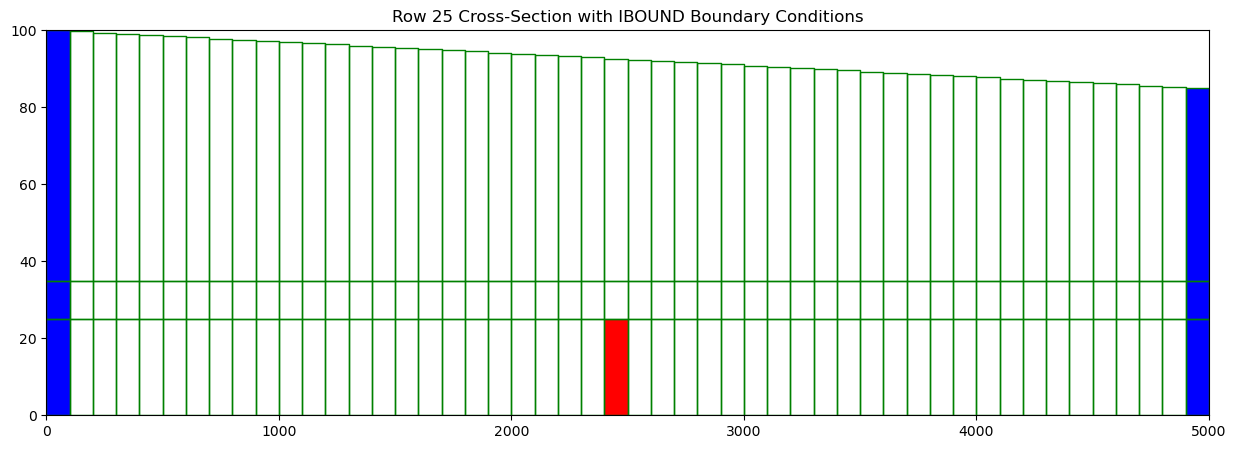

In [227]:
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instead
patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='green')
t = ax.set_title('Row 25 Cross-Section with IBOUND Boundary Conditions')

## 6. Recharge

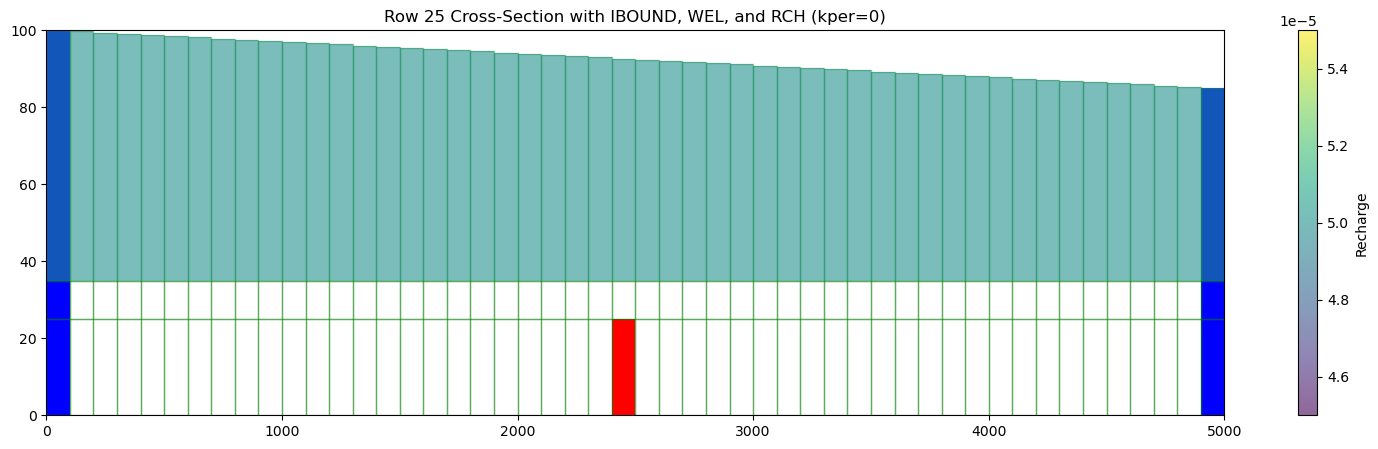

In [249]:
kper = 0  # choose stress period to display

fig, ax = plt.subplots(figsize=(19, 5))

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}, ax=ax)

xsect.plot_ibound(color_noflow='red', color_ch='blue')
xsect.plot_bc('WEL', kper=kper, color='red')
xsect.plot_grid(color='green', alpha=0.4)

# --- RCH is array-style, so plot it as an array ---
rch_arr = m3.rch.rech.array  # can be (nrow,ncol) or (nper,nrow,ncol)

if rch_arr.ndim == 3:
    rch2d = rch_arr[kper, :, :]
else:
    rch2d = rch_arr

rch3d = np.zeros((m3.nlay, m3.nrow, m3.ncol), dtype=float)
rch3d[0, :, :] = rch2d  # recharge applied to top layer

im = xsect.plot_array(rch3d, alpha=0.6)  # add cmap='Purples' if you want
plt.colorbar(im, ax=ax, label='Recharge')

ax.set_title(f'Row {24+1} Cross-Section with IBOUND, WEL, and RCH (kper={kper})')
plt.show()


# 7. Read in the outputs

### 7.1 Modflow outputs - Heads and budget files

In [229]:
# Head - 1 layer model 
headobj1 = bf.HeadFile(modelname1+'.hds')    #reads the binary head file
times = headobj1.get_times()                 #returns a list of timesteps
head1 = headobj1.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)
print(times)

#Head - 3 layer model 
headobj3 = bf.HeadFile(modelname3+'.hds')    #reads the binary head file
times = headobj3.get_times()                 #returns a list of timesteps
head3 = headobj3.get_data(totim=times[-1])   #returns a numpy array of heads for specified time (last timestep)


#Water balance - 1 layer
budgobj1 = bf.CellBudgetFile(modelname1+'.cbc')   #reads the cell budget file    
print(budgobj1.get_unique_record_names())
kstpkper_list1 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf1 = budgobj1.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff1 = budgobj1.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge1 = budgobj1.get_data(text='RECHARGE', totim=1.0) 


#Water balance - 3 layer
budgobj3 = bf.CellBudgetFile(modelname3+'.cbc')   #reads the cell budget file    
print(budgobj3.get_unique_record_names())
kstpkper_list3 = budgobj1.get_kstpkper()          #returns a list of stress periods & timesteps
frf3 = budgobj3.get_data(text='flow right face', totim=1.0) #returns an array of flow rates for right face of cells
fff3 = budgobj3.get_data(text='flow front face', totim=1.0) #returns an array of flow rates for front face of cells 
recharge3 = budgobj3.get_data(text='RECHARGE', totim=1.0) 
print(len(frf3))

[np.float32(1.0)]
[np.bytes_(b'   CONSTANT HEAD'), np.bytes_(b'FLOW RIGHT FACE '), np.bytes_(b'FLOW FRONT FACE '), np.bytes_(b'        RECHARGE')]
[np.bytes_(b'   CONSTANT HEAD'), np.bytes_(b'FLOW RIGHT FACE '), np.bytes_(b'FLOW FRONT FACE '), np.bytes_(b'FLOW LOWER FACE '), np.bytes_(b'        RECHARGE')]
1


# 8. Plotting
### 8.1 Cross section plots

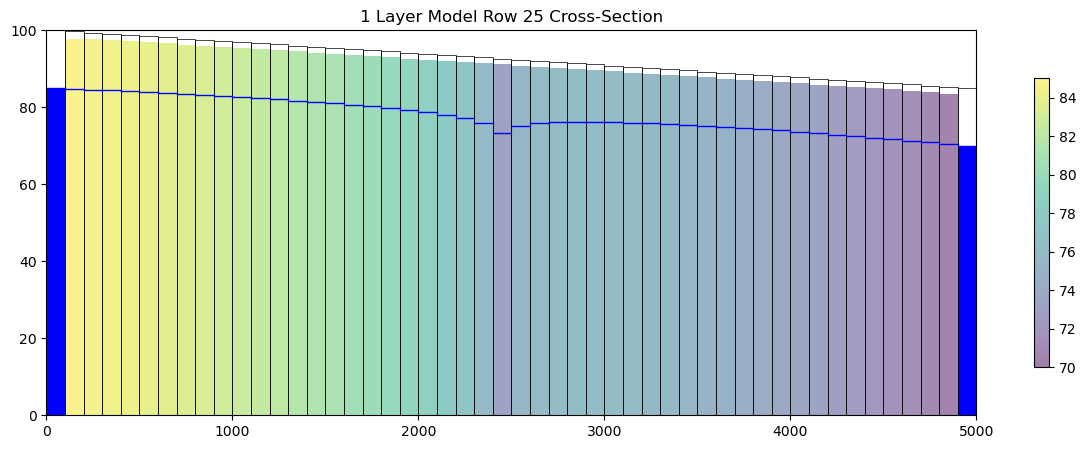

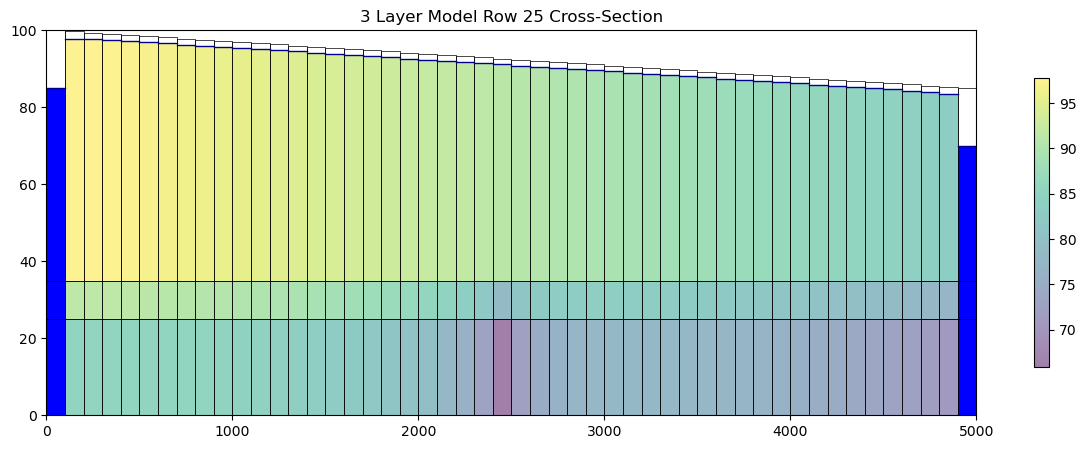

In [ ]:
#### 1 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m1, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head1, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head1)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('1 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head1[0,:,:], masked_values=[999.], color='blue', lw=1)


#### 3 layered model 
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)

xsect = flopy.plot.PlotCrossSection(model=m3, line={'row': 24}) #note use the key 'column' if you want to plot a column instaed
pc = xsect.plot_array(head3, masked_values=[999.], head=head3, alpha=0.5)
patches = xsect.plot_ibound(head=head3)
patches = xsect.plot_ibound(head=head3)
#patches = xsect.plot_ibound(color_noflow='red', color_ch='blue')
#patches = xsect.plot_bc('WEL', color='red')
linecollection = xsect.plot_grid(color='black', lw=0.5)
t = ax.set_title('3 Layer Model Row 25 Cross-Section')
cb = plt.colorbar(pc, shrink=0.75)
#Overlay the head in a layer of the model- in this case I'm doing the top layer i.e. head3[0,:,:]
wt = xsect.plot_surface(head3[0,:,:], masked_values=[999.], color='darkblue', lw=1)
#c1 = xsect.plot_surface(head3[1,:,:], masked_values=[999.], color='blue', lw=1)
#c2 = xsect.plot_surface(head3[2,:,:], masked_values=[999.], color='navy', lw=1)


# 9. Additional plots
### 9.1 Plot head transect

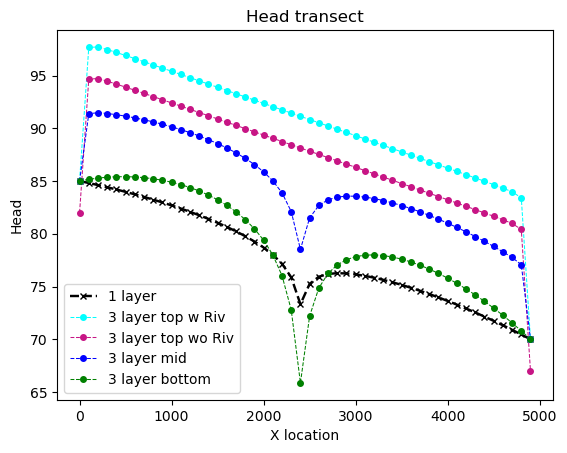

In [231]:
fig4 = plt.figure() 
ax = fig4.add_subplot(1, 1, 1)

x=np.arange(0, 5000, 100) 
plt.plot(x,head1[0,int(well_row),:], marker='x', color='black', markersize=4, linewidth="1.75", linestyle='--', label="1 layer")
if river:
    plt.plot(x,head3[0,int(well_row),:], marker='o', color='cyan', markersize=4, linewidth="0.75", linestyle='--', label="3 layer top w Riv")
plt.plot(x,head3[0,int(well_row),:]-(riv_hds if river else 0), marker='o', color='mediumvioletred', markersize=4, linewidth="0.75", linestyle='--', label="3 layer top wo Riv")
plt.plot(x,head3[1,int(well_row),:], marker='o', color='blue', markersize=4, linewidth="0.75", linestyle='--', label="3 layer mid")
plt.plot(x,head3[2,int(well_row),:], marker='o', color='green', markersize=4, linewidth="0.75", linestyle='--', label="3 layer bottom")
plt.title('Head transect')
plt.xlabel('X location')
plt.ylabel('Head')
plt.legend()

# plt.savefig('Head_Transect.png')

### 9.2 1 Layer Head Contours

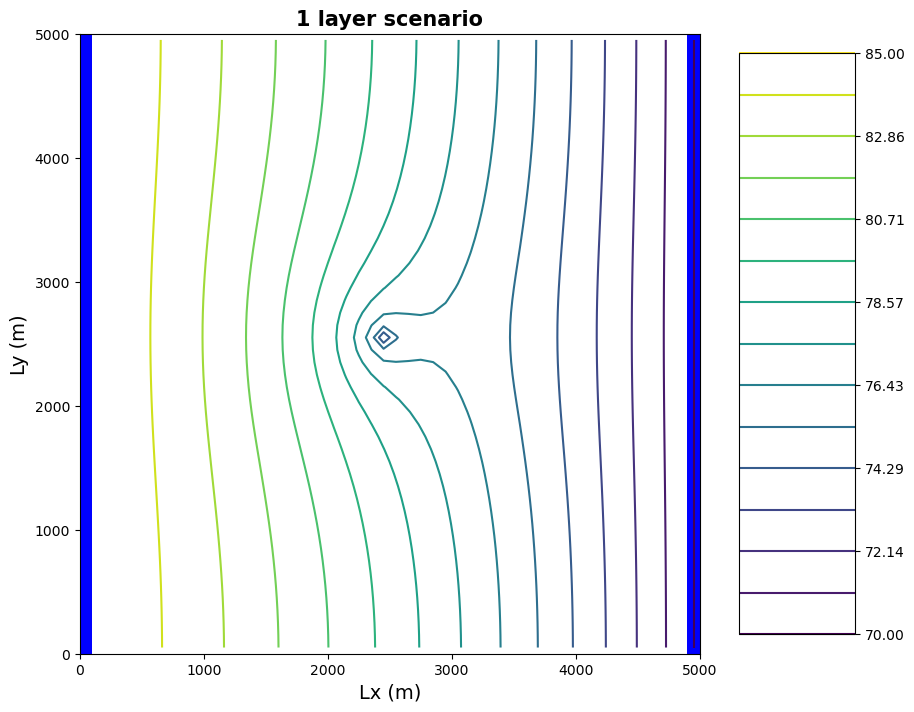

In [232]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))

modelmap = flopy.plot.PlotMapView(model=m1, layer=0) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head1[0].min(),head1[0].max(), 15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head1, levels=contour_levels) #create head contours


#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('1 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

### 9.3 3 Layer head contours

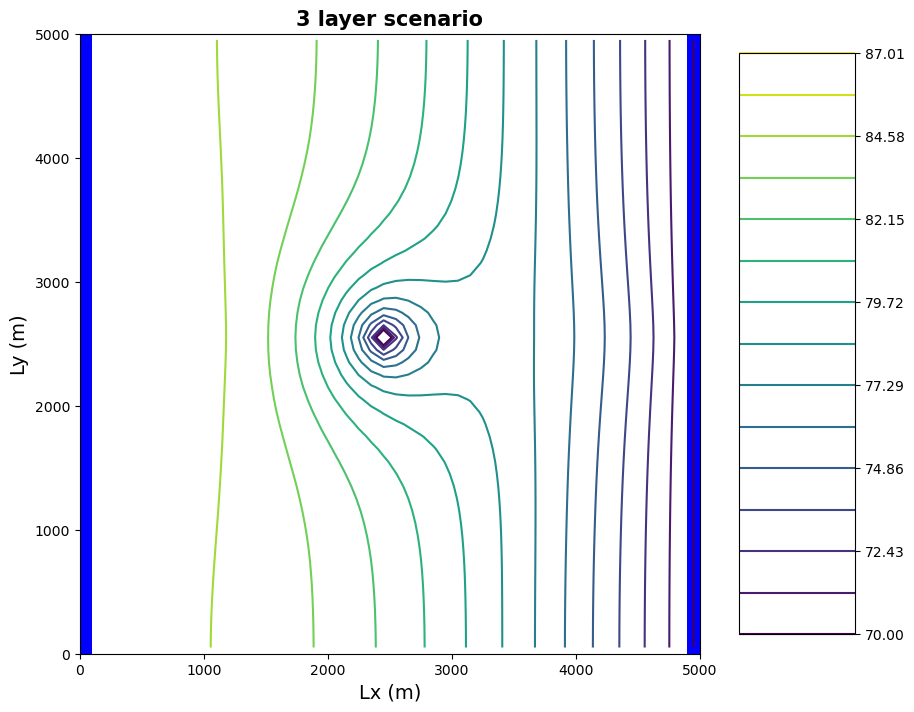

In [233]:
#f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
fig3=plt.figure(figsize=(10,10))
# print(fff1[0][0][40])
# print(frf3[0][2][40])

modelmap = flopy.plot.PlotMapView(model=m3, layer=2) #use modelmap to attach plot to model
#grid = modelmap.plot_grid() #plot model grid
qm = modelmap.plot_ibound()  
contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(), 15) #set contour levels for contouring head
head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours

#display parameters
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
plt.colorbar(head_contours,aspect=5)
#plt.show(modelmap)
#plt.savefig('WellScenario_vectors.png')   

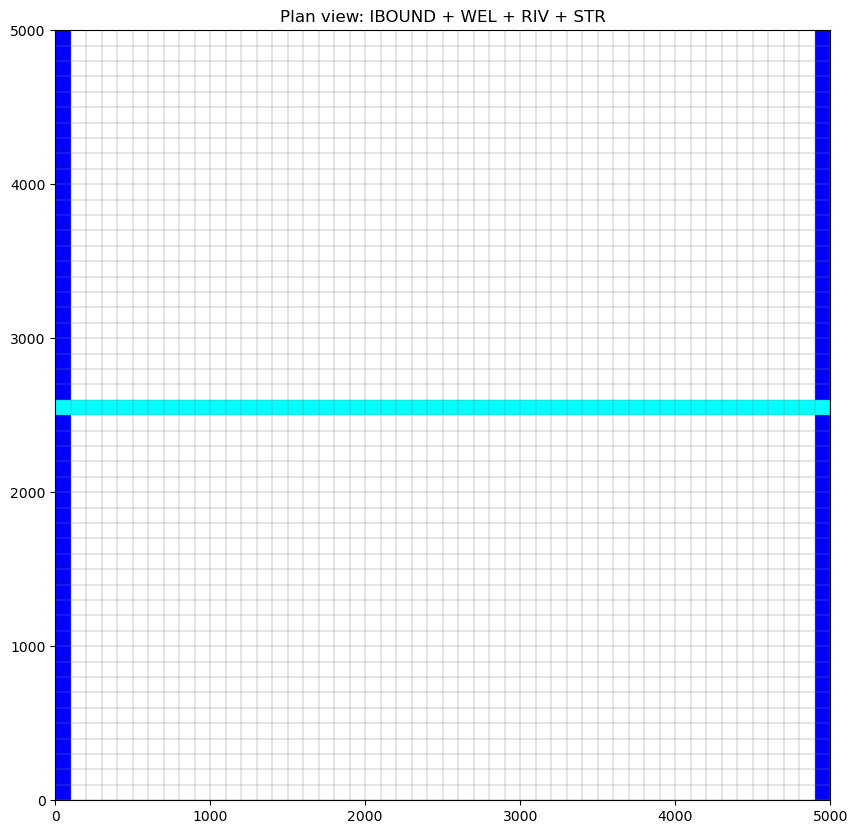

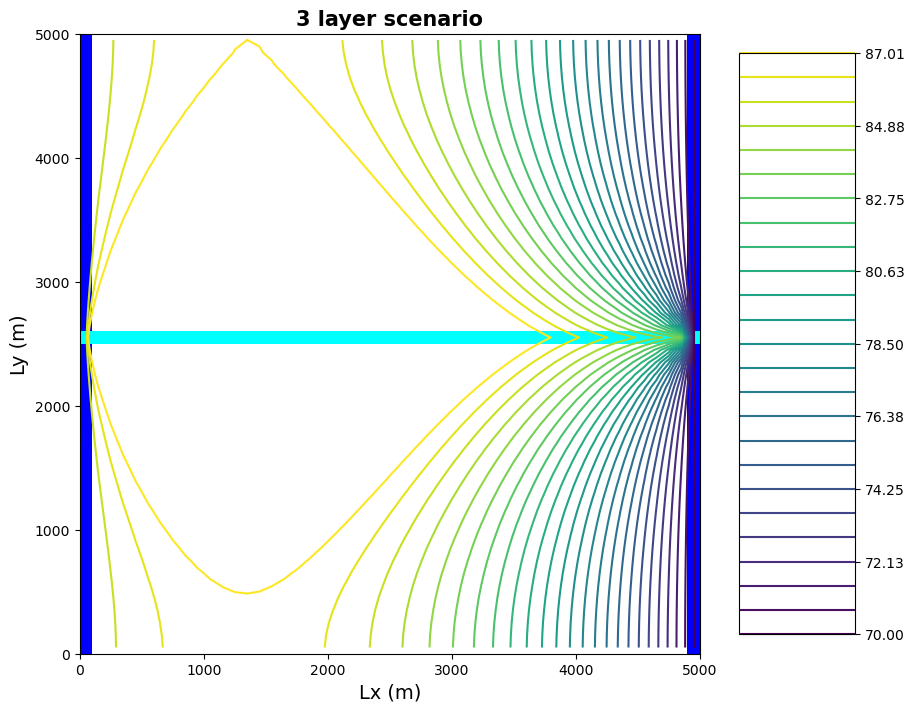

In [240]:
if river:
    fig, ax = plt.subplots(figsize=(10, 10))
    pmv = flopy.plot.PlotMapView(model=m3, layer=0, ax=ax)

    pmv.plot_grid(alpha=0.2)
    pmv.plot_ibound()
    pmv.plot_bc("RIV", color="cyan")

    ax.set_title("Plan view: IBOUND + WEL + RIV + STR")
    plt.show()

    #f, axes = plt.subplots(ncols=1, nrows=2, figsize=(5, 10))
    fig4=plt.figure(figsize=(10,10))

    modelmap = flopy.plot.PlotMapView(model=m3, layer=0) #use modelmap to attach plot to model
    #grid = modelmap.plot_grid() #plot model grid
    qm = modelmap.plot_ibound()
    modelmap.plot_bc("RIV", color="cyan")
    contour_levels = np.linspace(head3[0][0].min(),head3[0][0].max(), 25) #set contour levels for contouring head
    head_contours = modelmap.contour_array(head3, levels=contour_levels) #create head contours

    #display parameters
    plt.xlabel('Lx (m)',fontsize = 14)
    plt.ylabel('Ly (m)',fontsize = 14)
    plt.title('3 layer scenario', fontsize = 15, fontweight = 'bold')
    plt.colorbar(head_contours,aspect=5)
    #plt.show(modelmap)
    #plt.savefig('WellScenario_vectors.png')   

In [235]:
if river:
    print(m3.get_package("RIV"))
    print("RIV cells (kper 0):", len(m3.riv.stress_period_data[0]))



    MODFLOW River Package Class.

    Parameters
    ----------
    model : model object
        The model object (of type :class:`flopy.modflow.mf.Modflow`) to which
        this package will be added.
    ipakcb : int, optional
        Toggles whether cell-by-cell budget data should be saved. If None or zero,
        budget data will not be saved (default is None).
    stress_period_data : list, recarray, dataframe, or dictionary of boundaries.
        Each river cell is defined through definition of
        layer (int), row (int), column (int), stage (float), cond (float),
        rbot (float).
        The simplest form is a dictionary with a lists of boundaries for each
        stress period, where each list of boundaries itself is a list of
        boundaries. Indices of the dictionary are the numbers of the stress
        period. This gives the form of::

            stress_period_data =
            {0: [
                [lay, row, col, stage, cond, rbot],
                [lay, 